<a href="https://colab.research.google.com/github/m-kazuki/reservoirNet/blob/fujino/reservoirNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
cd drive/My\ Drive/reservoirNet

/content/drive/My Drive/reservoirNet


In [0]:
!pip install bindsnet

     |████████████████████████████████| 71kB 2.8MB/s 
     |████████████████████████████████| 204kB 10.0MB/s 
  Created wheel for bindsnet: filename=bindsnet-0.2.7-cp36-none-any.whl size=81417 sha256=14b76c9187b88bbd73b5f6a1d9754b1ad08a9bb8f0fdd2a83e81551908cc1320
  Stored in directory: /root/.cache/pip/wheels/d3/68/80/eca244a3d072961b5152d5906475ffc9d9b2453c9e060535e3
Successfully built bindsnet


In [0]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import argparse
import matplotlib.pyplot as plt

from torchvision import transforms
from tqdm import tqdm_notebook as tqdm
from bindsnet.analysis.plotting import (
    plot_input,
    plot_spikes,
    plot_voltages,
    plot_weights,
)
from bindsnet.datasets import MNIST
from bindsnet.encoding import PoissonEncoder
from bindsnet.network import Network
from bindsnet.network.nodes import Input

# Build a simple two-layer, input-output network.
from bindsnet.network.monitors import Monitor
from bindsnet.network.nodes import LIFNodes
from bindsnet.network.topology import Connection
from bindsnet.utils import get_square_weights

import easydict

In [0]:
args = easydict.EasyDict({
        "seed": 0,
        "n_neurons": 500,
        "n_epochs": 120,
        "n_examples": 1000,
        "n_workers": -1,
        "time": 251,
        "dt": 1.0,
        "intensity": 64,
        "progress_interval": 10,
        "update_interval": 250,
        "gpu": True,
        "device_id": 0,
        "train": True
})
seed = args.seed
n_neurons = args.n_neurons
n_epochs = args.n_epochs
n_examples = args.n_examples
n_workers = args.n_workers
time = args.time
dt = args.dt
intensity = args.intensity
progress_interval = args.progress_interval
update_interval = args.update_interval
train = args.train
gpu = args.gpu
device_id = args.device_id
n_iters = n_examples

np.random.seed(seed)
torch.cuda.manual_seed_all(seed)
torch.manual_seed(seed)

# Sets up Gpu use
if gpu and torch.cuda.is_available():
    torch.cuda.set_device(device_id)
    # torch.set_default_tensor_type('torch.cuda.FloatTensor')
else:
    torch.manual_seed(seed)

In [0]:
# dt: the simulation time step
network = Network(dt=dt)

# 入力層
inpt = Input(2, shape=(1,2))
network.add_layer(inpt, name="I")

# リザーバー層
output = LIFNodes(n_neurons, thresh=-52 + np.random.randn(n_neurons).astype(float))
network.add_layer(output, name="O")

# 入力層->リザーバー層とリザーバー層->リザーバー層のコネクションを作成
C1 = Connection(source=inpt, target=output, w=torch.randn(inpt.n, output.n))
C2 = Connection(source=output, target=output, w=torch.randn(output.n, output.n))
network.add_connection(C1, source="I", target="O")
network.add_connection(C2, source="O", target="O")

# スパイクのモニター(入力、リザーバー)
spikes = {}
for l in network.layers:
    spikes[l] = Monitor(network.layers[l], ["s"], time=time)
    network.add_monitor(spikes[l], name="%s_spikes" % l)

# ボルトのモニター(リザーバー)
voltages = {"O": Monitor(network.layers["O"], ["v"], time=time)}
network.add_monitor(voltages["O"], name="O_voltages")

# Directs network to GPU
if gpu:
    network.to("cuda")

# dataset作成
class MyDataset(torch.utils.data.Dataset):
    # xy.shape = (n, time, xy)
    # F.shape = (n, time, F)
    def __init__(self, xy, F, transform=None):
        self.transform = transform
        self.data_num = xy.shape[0]
        self.data = xy
        self.label = F

    def __len__(self):
        return self.data_num

    def __getitem__(self, idx):
        out_data = self.data[idx]
        out_label =  self.label[idx]

        if self.transform:
            out_data = self.transform(out_data)

        return out_data, out_label

train_data = pd.read_csv("train_data.csv", header = None)
train_data = np.array(train_data)
train_data = train_data.reshape((1000,251,4))
# from IPython.core.debugger import Pdb; Pdb().set_trace()
xy = train_data[:900,:,0:2]
F = train_data[:900,:,2:4]
dataset = MyDataset(xy, F, transform=None)

# Create a dataloader to iterate and batch data
dataloader = torch.utils.data.DataLoader(
    dataset, batch_size=1, shuffle=True, num_workers=0, pin_memory=gpu
)

# Run training data on reservoir computer and store (spikes per neuron, label) per example.
train_pairs = []
pbar = tqdm(enumerate(dataloader))

# 
# このループではトレーニングデータを作成していると考えて良い
# q = int((bs-1)/2)
for (i, dataPoint) in pbar:
    # data, labelを取り出している
    datum = dataPoint[0].view(time, 2).to(device_id)
    label = dataPoint[1].view(time, 2)
    pbar.set_description_str("Train progress: (%d / %d)" % (i, n_iters))
    # 時間を1つ進める
    for j in range(50):
      network.run(inputs={"I": datum[0]}, time=1, input_time_dim=1)
    for j in range(251):
      network.run(inputs={"I": datum[0]}, time=1, input_time_dim=1)
#      # リザーバー層の状態とラベルをトレーニングデータとして保存
      train_pairs.append([spikes["O"].get("s").sum(0), label[j]])
      network.run(inputs={"I": datum[0]}, time=1, input_time_dim=1)
#      for l in range(3):
#        network.run(inputs={"I": datum[0]}, time=1, input_time_dim=1)
      #network.run(inputs={"I": datum[0]}, time=1, input_time_dim=1)
#    network.run(inputs={"I": datum}, time=251, input_time_dim=1)
#    train_pairs.append([spikes["O"].get("s").sum(0), label])
    network.reset_state_variables()
#const = torch.tensor([1]).to(device_id)
#for j in range(len(train_pairs)):
#  train_pairs[j][0] = torch.cat([train_pairs[j][0][0],const])
np.save("training_pairs", train_pairs)
# Define logistic regression model using PyTorch.

In [0]:
xy = train_data[900:,:,0:2]
F = train_data[900:,:,2:4]
dataset = MyDataset(xy, F, transform=None)

# Create a dataloader to iterate and batch data
dataloader = torch.utils.data.DataLoader(
    dataset, batch_size=1, shuffle=True, num_workers=0, pin_memory=gpu
)

# Run training data on reservoir computer and store (spikes per neuron, label) per example.
test_pairs = []
pbar = tqdm(enumerate(dataloader))

# 
# このループではトレーニングデータを作成していると考えて良い
# q = int((bs-1)/2)
for (i, dataPoint) in pbar:
    # data, labelを取り出している
    datum = dataPoint[0].view(time, 2).to(device_id)
    label = dataPoint[1].view(time, 2)
    pbar.set_description_str("Train progress: (%d / %d)" % (i, n_iters))
    # 時間を1つ進める
    for j in range(50):
      network.run(inputs={"I": datum[0]}, time=1, input_time_dim=1)
    for j in range(251):
      network.run(inputs={"I": datum[0]}, time=1, input_time_dim=1)
#      # リザーバー層の状態とラベルをトレーニングデータとして保存
      test_pairs.append([spikes["O"].get("s").sum(0), label[j]])
      network.run(inputs={"I": datum[0]}, time=1, input_time_dim=1)
#      for l in range(3):
#        network.run(inputs={"I": datum[0]}, time=1, input_time_dim=1)
      #network.run(inputs={"I": datum[0]}, time=1, input_time_dim=1)
#    network.run(inputs={"I": datum}, time=251, input_time_dim=1)
#    test_pairs.append([spikes["O"].get("s").sum(0), label])
    network.reset_state_variables()
#const = torch.tensor([1]).to(device_id)
#for j in range(len(test_pairs)):
#  test_pairs[j][0] = torch.cat([test_pairs[j][0][0],const])
np.save("test_pairs", test_pairs)
# Define logistic regression model using PyTorch.

In [0]:
class NN(nn.Module):
    def __init__(self, input_size):
        super(NN, self).__init__()
        self.linear_1 = nn.Linear(input_size, 500)
        self.linear_2 = nn.Linear(500, 2)
        # self.dropout1 = nn.Dropout(p=0.05)
        self.dropout2 = nn.Dropout(p=0.5)
        self.linear = nn.Linear(input_size, 2)

    def forward(self, x):
        # out = self.dropout1(x.float().view(-1))
        # out = torch.relu(self.linear_1(out))
        out = torch.relu(self.linear_1(x.float().view(-1)))
        out = self.dropout2(out)
        out = self.linear_2(out)
        return out

In [0]:
training_pairs = np.load("training_pairs.npy", allow_pickle=True)
# training_pairs = training_pairs[:2510,:]

In [0]:
# Create and train logistic regression model on reservoir outputs.
model = NN(n_neurons).to(device_id)
criterion = torch.nn.MSELoss(reduction="sum")
# optimizer = torch.optim.SGD(model.parameters(), lr=1e-4, momentum=0.9)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, betas=(0.5, 0.999))

# Training the Model
# 回帰モデルを先ほど生成したデータでトレーニング
print("\n Training the read out")
model.train()
# model.load_state_dict(torch.load("model"))
pbar = tqdm(enumerate(range(n_epochs)))
for epoch, _ in pbar:
    avg_loss = 0
    for i, (s, l) in enumerate(training_pairs):
        # Forward + Backward + Optimize
        optimizer.zero_grad()
        outputs = model(s.view(-1))
        label = l.float().to(device_id)
        loss = criterion(outputs, label)
        avg_loss += loss.data
        loss.backward()
        optimizer.step()
    pbar.set_description_str(
        "Epoch: %d/%d, Loss: %.4f"
        % (epoch + 1, n_epochs, avg_loss / len(training_pairs))
    )

torch.save(model.state_dict(), "model_dropout")
"""
test_pairs = []
pbar = tqdm(enumerate(dataloader))
for (i, dataPoint) in pbar:
    datum = dataPoint[0].view(time, 2)
    labels = dataPoint[1].view(time, 2)
    pbar.set_description_str("Testing progress: (%d / %d)" % (i, n_iters))

    for j in range(q, datum.shape[0]-q):
        data = datum[ j-q : j+q+1 ].to(device_id)
        data = data[np.newaxis,np.newaxis,:,:]
        label = labels[j]
        # 時間を1つ進める
        network.run(inputs={"I": data}, time=1, input_time_dim=1)
        # リザーバー層の状態とラベルをトレーニングデータとして保存
        test_pairs.append([spikes["O"].get("s").sum(0), label])

    network.reset_state_variables()

np.save("test_pairs", test_pairs)
"""
# test_pairs = np.load("test_pairs.npy", allow_pickle=True)


 Training the read out


In [0]:
# パラメータの読み込み
param = torch.load('model_dropout')
model = NN(n_neurons).to(device_id)
criterion = torch.nn.MSELoss(reduction="sum")
model.load_state_dict(param)
model.eval()
loss, total = 0, 0
k = 0
test_pairs = np.load("test_pairs.npy", allow_pickle=True)
outs = np.zeros([251*100,2])
labels = np.zeros([251*100,2])
for s, label in test_pairs:
    k += 1
    outputs = model(s)
    outs[k-1,:] = np.array(outputs.cpu().detach().numpy())
    labels[k-1,:] = np.array(label.cpu().detach().numpy())
    loss += criterion(outputs, label.float().to(device_id)).data
    total += 1
    #if k == 251:
    #  break

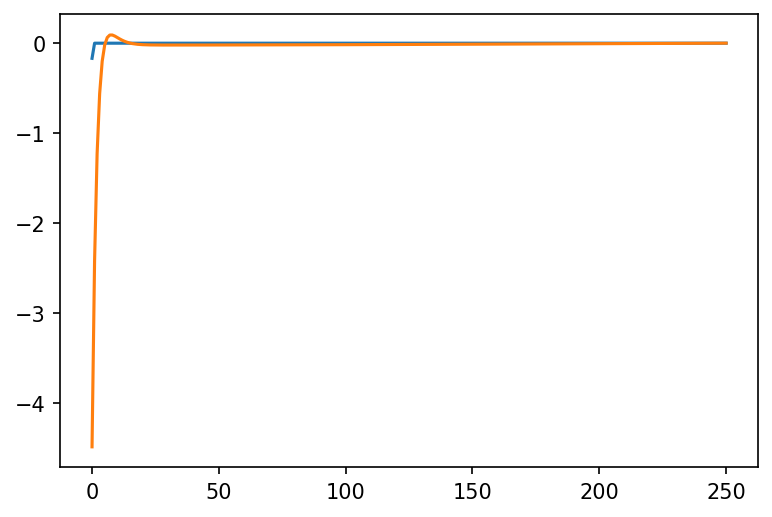

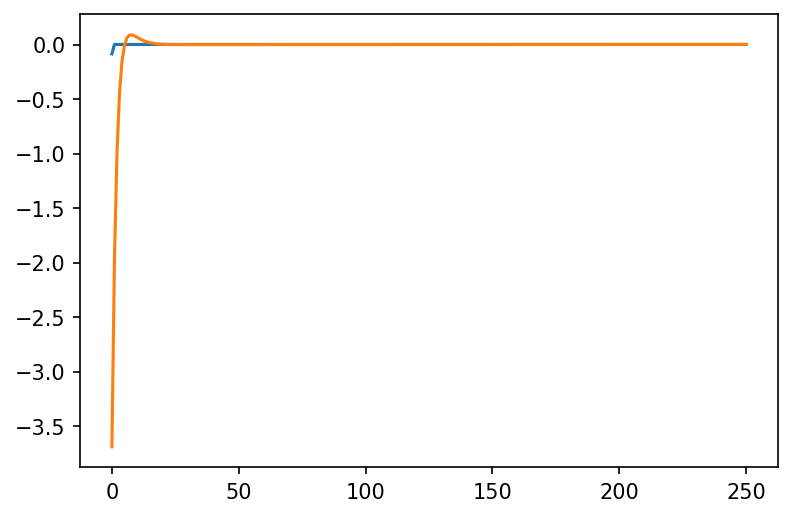

In [0]:
l = 0
a = 251*l
b = a + 251
plt.figure(dpi=150)
plt.plot(outs[a:b,0])
plt.plot(labels[a:b,0])
plt.show()
plt.figure(dpi=150)
plt.plot(outs[a:b,1])
plt.plot(labels[a:b,1])
plt.show()

In [0]:
np.savetxt("test.csv",outs)
np.savetxt("ans.csv",labels)